In [53]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [69]:
class Problem(object):
    def __init__(self,n_cities):
        self.tsp=self.setup_tsp(n_cities)
        #self.a=agent()

    def setup_tsp(self,n_cities):

        #locations
        x=np.random.permutation(range(0,n_cities))
        y=np.random.permutation(range(0,n_cities))

        #nodes
        g=nx.Graph()
        for i in range(0,n_cities):
            g.add_node(i,loc=(x[i],y[i]))

        #edges
        cg=nx.complete_graph(n_cities)
        for u,v in cg.edges():
            #get distance
            #d=((g.node[u]['loc'][0]-g.node[v]['loc'][0])**2+(g.node[u]['loc'][1]-g.node[v]['loc'][1])**2)**.5
            #print u,v,d
            g.add_edge(u,v) #g.add_edge(u,v,dist=d)
        #plt.scatter(x,y)

        return g
    
    

In [84]:
class agent(object):
    def __init__(self,perspective):
        self.k=nx.DiGraph()
        self.score=perspective
        self.landscape={}
        
    def solve(self,tsp):
        #random route
        r=np.random.permutation(tsp.nodes())
        
        #score route
        s,k_r=self.score(r,tsp)
        
        #Save route and score
        self.landscape[r]=s
        
        
        
        
        
        
    

In [85]:
def perspective(route,tsp):
    s=0.0
    k={}
    for i in xrange(len(route)-1):
        u=route[i]
        v=route[i+1]
        d=((g.node[u]['loc'][0]-g.node[v]['loc'][0])**2+(g.node[u]['loc'][1]-g.node[v]['loc'][1])**2)**.5
        k[(u,v)]=d
        s+=d
        
    return s,k
    

In [4]:
g=nx.complete_graph(4)
print g.nodes()
print g.edges()
print g

[0, 1, 2, 3]
[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
complete_graph(4)


In [11]:
np.random.permutation(range(0,4))

array([2, 3, 1, 0])

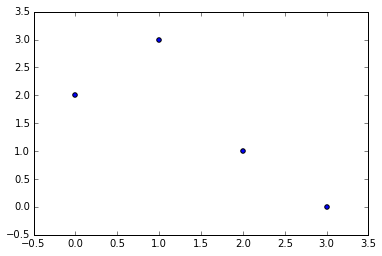

In [80]:
g=setup_tsp(4)


In [81]:
print g.nodes(data=True)
print g.edges(data=True)

[(0, {'loc': (3, 0)}), (1, {'loc': (0, 2)}), (2, {'loc': (2, 1)}), (3, {'loc': (1, 3)})]
[(0, 1, {'dist': 3.6055512754639891}), (0, 2, {'dist': 1.4142135623730951}), (0, 3, {'dist': 3.6055512754639891}), (1, 2, {'dist': 2.2360679774997898}), (1, 3, {'dist': 1.4142135623730951}), (2, 3, {'dist': 2.2360679774997898})]


In [38]:
g.node[0]

{'loc': (0, 3)}

In [54]:
plt.scatter(x,y)

NameError: name 'x' is not defined

In [70]:
p=Problem(4)

In [72]:
p.tsp.nodes()

[0, 1, 2, 3]

In [75]:
l=[0,1,2,3]
for i in xrange(len(l)-1):
    print l[i],l[i+1]

0 1
1 2
2 3


In [86]:
perspective([0,2,1,3],g)

(5.0644951022459797,
 {(0, 2): 1.4142135623730951,
  (1, 3): 1.4142135623730951,
  (2, 1): 2.2360679774997898})